In [2]:
%%capture
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %cd .. 
import sys
sys.path.append("..")
import statnlpbook.util as util
import statnlpbook.sequence as seq
import matplotlib
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)

<!---
Latex Macros
-->
$$
\newcommand{\Xs}{\mathcal{X}}
\newcommand{\Ys}{\mathcal{Y}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\balpha}{\boldsymbol{\alpha}}
\newcommand{\bbeta}{\boldsymbol{\beta}}
\newcommand{\aligns}{\mathbf{a}}
\newcommand{\align}{a}
\newcommand{\source}{\mathbf{s}}
\newcommand{\target}{\mathbf{t}}
\newcommand{\ssource}{s}
\newcommand{\starget}{t}
\newcommand{\repr}{\mathbf{f}}
\newcommand{\repry}{\mathbf{g}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\prob}{p}
\newcommand{\bar}{\,|\,}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\DeclareMathOperator{\argmin}{argmin}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
\newcommand{\length}[1]{\text{length}(#1) }
\newcommand{\indi}{\mathbb{I}}
$$

# Sequence Labelling 
assigns labels to each element in a sequence

## Example: PoS tagging

assign each token in a sentence its **Part-of-Speech tag**

|I | predict | I | won't | win | a | single | game |
|-|
|O | V | O | V | V | D | A | N |



## Example: Named Entity Recognition

label tokens as beginning (B), inside (I) our outside (O) a **named entity**

| Barack | Obama | was |  born | in | Hawaii |
|-|
| B-PER | I-PER | O |  O | O | B-LOC |


## Sequence Labelling as Structured Prediction

* Input Space $\Xs$: sequences of items to label
* Output Space $\Ys$: sequences of output labels labels
* Model: $s_{\params}(\x,\y)$
* Prediction: $\argmax_\y s_{\params}(\x,\y)$

## Conditional Models
model probability distributions over label sequences $\y$ conditioned on input sequences $\x$
$$
s_{\params}(\x,\y) = \prob_\params(\y|\x)
$$ 

* analog to conditional models of [text classification](doc_classify.ipynb) chapter

## Part-of-Speech Tagging as Sequence Labelling
We us PoS tagging for tweets and use the [Tweebank dataset](http://www.cs.cmu.edu/~ark/TweetNLP/#pos) 

In [4]:
train = seq.load_tweebank("../data/oct27.splits/oct27.train")
dev = seq.load_tweebank("../data/oct27.splits/oct27.dev")
test = seq.load_tweebank("../data/oct27.splits/oct27.test")
" ".join([w + "/" + t for w,t in zip(train[0][0],train[0][1])])

"I/O predict/V I/O won't/V win/V a/D single/A game/N I/O bet/V on/P ./, Got/V Cliff/^ Lee/^ today/N ,/, so/P if/P he/O loses/V its/L on/P me/O RT/~ @e_one/@ :/~ Texas/^ (/, cont/~ )/, http://tl.gd/6meogh/U"

Tags (such as "O", "V" and "^") are described in the [Tweebank annotation guideline](http://www.cs.cmu.edu/~ark/TweetNLP/annot_guidelines.pdf)

In [6]:
# count tags here?`xw
from collections import defaultdict
import pandas as pd
examples = {}
counts = defaultdict(int)
words = defaultdict(set)
for x,y in train:
    for i in range(0, len(x)):
        if y[i] not in examples:
            examples[y[i]] = [x[j] + "/" + y[j] if i == j else x[j] for j in range(max(i-2,0),min(i+2,len(x)-1))]
        counts[y[i]] += 1
        words[y[i]].add(x[i])
sorted_tags = sorted(counts.items(),key=lambda x:-x[1])
sorted_tags_with_examples = [(t,c,len(words[t])," ".join(examples[t])) for t,c in sorted_tags]

sorted_tags_table = pd.DataFrame(sorted_tags_with_examples, columns=['Tag','Count','Unique Words','Example'])

In [7]:
sorted_tags_table[:10]

,Tag,Count,Unique Words,Example
0,V,2219,873,I predict/V I
1,N,2003,1377,a single game/N I
2,",",1715,84,"bet on ./, Got"
3,P,1252,126,I bet on/P .
4,O,1063,97,I/O predict
5,^,890,741,. Got Cliff/^ Lee
6,D,869,68,won't win a/D single
7,A,755,449,win a single/A game
8,@,713,694,me RT @e_one/@ :
9,R,689,217,but I still/R hate


## Local Models / Classifiers
A **fully factorised** or **local** model:

$$
p_\params(\y|\x) = \prod_{i=1}^n p_\params(y_i|\x,i)
$$

* labels are independent of each other
* inference (and hence training) in this model is trivial
* Compare to ["Naive Translation Model"](word_mt.ipynb)

### Example

$$
\prob_\params(\text{D A N} \bar \text{a single game}) = \\\\ \prob_\params(\text{D}\bar \text{a single game},1) \prob_\params(\text{A} \bar \text{a single game},2) \ldots
$$

## Factor Graphs

show 

* **variables** as circles, such as $y_1$
* **terms** (**factors**) as filled rectangles, such as $f_2= \prob_\params(\text{A} \bar \text{a single game},2) \ldots$
* **observations** as shaded nodes

$$
\prob_\params(y_1 \bar \x, 1) \prob_\params(y_2 \bar \x, 2) \prob_\params(y_3 \bar \x, 3)  \ldots
$$

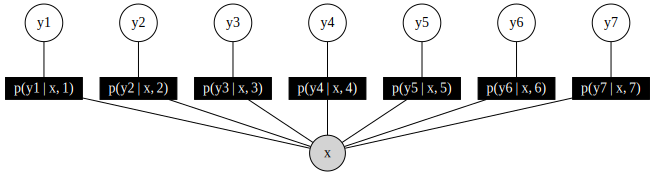

In [6]:
seq.draw_local_fg(7)

**Sequence of classification models** instead of single structured model 

### Tag Classifier

Learn classifier $p_\params(y\bar\x,i)$ to predict class for sentence $\x$ and position $i$

$$
  p_\params(y\bar\x,i) = \frac{1}{Z_\x} \exp \langle \repr(\x,i),\params_y \rangle
$$

### What Features?

Word at token to tag:
$$
\repr_w(\x,i) = \begin{cases}1 \text{ if }x_i=w \\\\ 0 \text{ else} \end{cases}
$$

In [11]:
def feat_1(x,i):
    return {
        'word:' + str(x[i]): 1.0
    }
local_1 = seq.LocalSequenceLabeler(feat_1, train)

We can assess the accuracy of this model on the development set.

In [10]:
seq.accuracy(dev, local_1.predict(dev))

0.6392286958324694

### How to Improve?

Look at **confusion matrix**

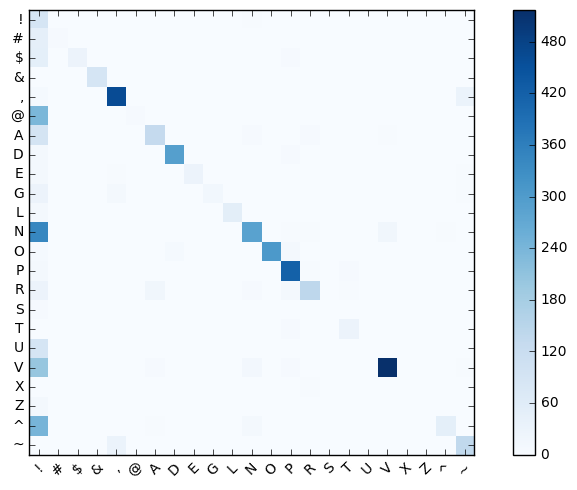

In [9]:
seq.plot_confusion_matrix(dev, local_1.predict(dev))

Shows:

* strong diagonal (good predictions)
* `N` receives a lot of wrong counts 
* `@` complete failure

Let us start with @ ... 

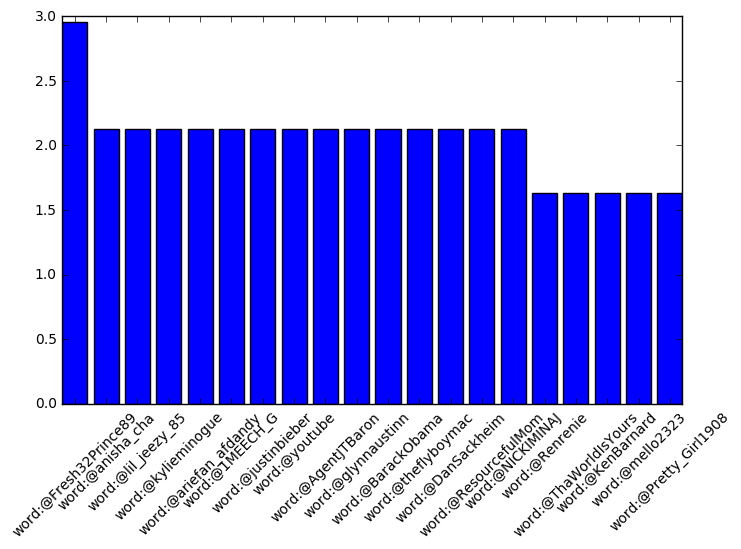

In [10]:
local_1.plot_lr_weights('@')

Features for **specific users** such as "word=@justinbieber" do not generalise well

How to address this? 

In [12]:
def feat_2(x,i):
    return {
        **feat_1(x,i),
        'first_at:' + str(x[i][0:1] == '@'): 1.0
    }
local_2 = seq.LocalSequenceLabeler(feat_2, train)
seq.accuracy(dev, local_2.predict(dev))

0.7484967862326353

To confirm that these results actually from improved '@' prediction, let us look at the confusion matrix again.

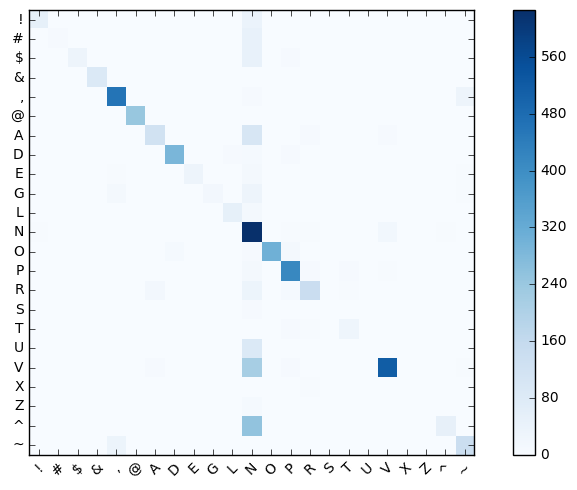

In [12]:
seq.plot_confusion_matrix(dev, local_2.predict(dev))

Solved! 

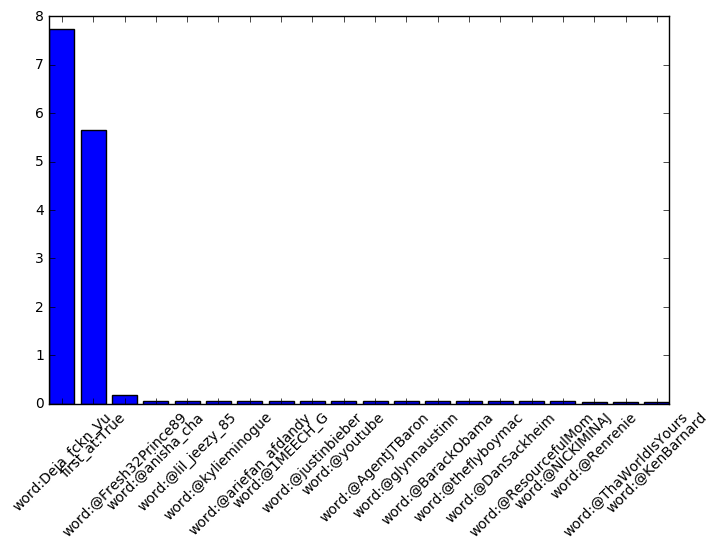

In [13]:
local_2.plot_lr_weights('@')

Other errors?

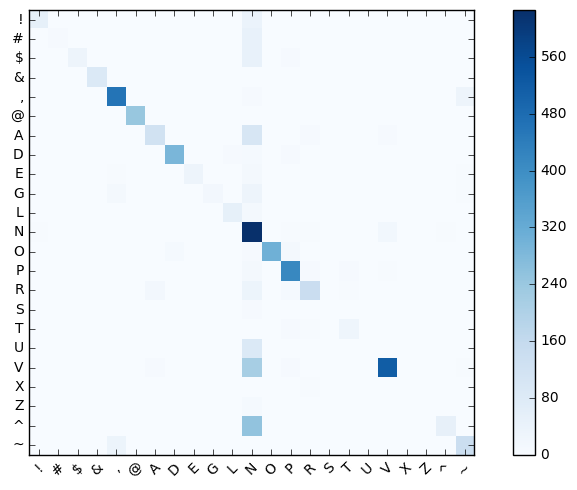

In [14]:
seq.plot_confusion_matrix(dev, local_2.predict(dev))

Look for errors with high frequency:

* distinguishing **proper nouns** (label '^') such as "McDonals" or "smash burger" 
* from **common nouns** (label 'N') such as "wife" or "rain". 

### Micro View
How do these errors look like?

In [15]:
util.Carousel(local_2.errors(dev[:10], 
                             filter_guess=lambda y: y=='N',
                             filter_gold=lambda y: y=='^'))

Proper nouns tend to be capitalised!

In [16]:
def feat_3(x,i):
    return {
        **feat_2(x,i),
        'is_lower:' + str(x[i].islower()): 1.0
    }
local_3 = seq.LocalSequenceLabeler(feat_3, train, C=10)
seq.accuracy(dev, local_3.predict(dev))

0.771511507360564

This improvement indeed comes from being able to identify proper nouns when they are capitalised:

In [17]:
util.Carousel(local_3.errors(dev[:10], 
                             filter_guess=lambda y: y=='N',
                             filter_gold=lambda y: y=='^'))

Find more problems:

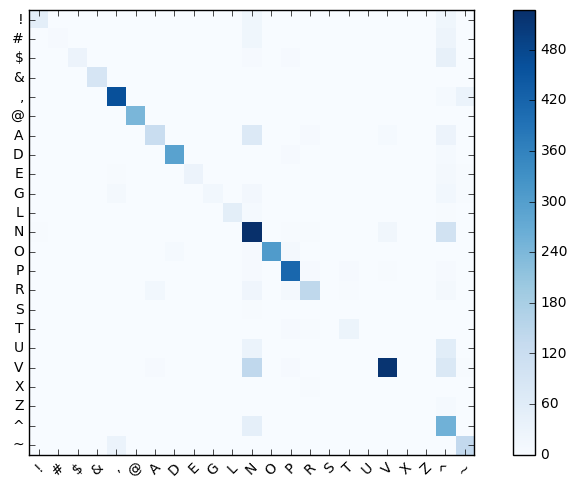

In [18]:
seq.plot_confusion_matrix(dev, local_3.predict(dev))

High frequency error: 

* misclassifying verbs ('V') as common nouns ('N')

Inspect examples... 

In [19]:
util.Carousel(local_3.errors(dev[:20], 
                             filter_guess=lambda y: y=='N',
                             filter_gold=lambda y: y=='V'))

* "laughing", "blowing" or "passed" are misclassified as common nouns 
* For $f_{\text{word},w}$ feature template weights are $0$ 

Suggests that word has not appeared (or not appeared as a verb) in the training set! 

However, we can tell that these words may be verbs:

* check suffixes such as "ing" or "ed". 

Incorporate as features!

In [20]:
def feat_4(x,i):
    return {
        **feat_3(x,i),
        'last_3' + "".join(x[i][-3:]): 1.0,
        'last_2' + "".join(x[i][-2:]): 1.0,
    }
local_4 = seq.LocalSequenceLabeler(feat_4, train)
seq.accuracy(dev, local_4.predict(dev))

0.7876840140991085

In [21]:
util.Carousel(local_4.errors(dev[:20], 
                             filter_guess=lambda y: y=='N',
                             filter_gold=lambda y: y=='V' ))

## Markov Models
We have **dependencies** between consecutive labels

### Example

after non-possessive pronoun ("O") such as "I" a verb ("V") is more likely than a noun ("N")

*local* model cannot capture this

## Maximum Entropy Markov Model
$$
p_\params(\y|\x) = \prod_{i=1}^n p_\params(y_i|\x,y_{i-1},i)
$$

a product of local logistic regression (aka Maximum Entropy) classifiers $\prob_\params(y_i|\x,y_{i-1},i)$

* but classifiers can use the previous label as observed feature 
* makes a **first-order Markov assumption**



### Example

$$
\prob_\params(\text{D A N} \bar \text{a single game}) = \\\\ \prob_\params(\text{D}\bar \text{a single game},\text{PAD},1) \prob_\params(\text{A} \bar \text{a single game},\text{D},2) \ldots
$$

Log-linear version with access to previous label: 

$$
  p_\params(y_i|\x,y_{i-1},i) = \frac{1}{Z_{\x,y_{i-1},i}} \exp \langle \repr(\x,y_{i-1},i),\params_{y_i} \rangle
$$

where $Z_{\x,y_{i-1},i}=\sum_y \exp \langle \repr(\x,y_{i-1},i),\params_{y_i} \rangle $ is a *local* per-token normalisation factor.

### Factor Graph View

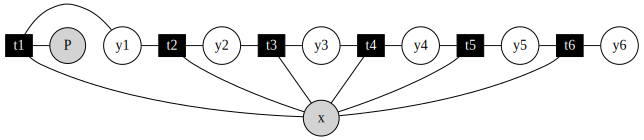

In [22]:
seq.draw_transition_fg(7)

### Training MEMMs
Optimising the conditional likelihood 

$$
\sum_{(\x,\y) \in \train} \log \prob_\params(\y|\x)
$$

Decomposes nicely: 
$$
\sum_{(\x,\y) \in \train} \sum_{i=1}^{|\x|} \log \prob_\params(y_i|\x,y_{i-1},i)   
$$

Easy to train
* Equivalent to a **logistic regression objective** for a classifier that assigns labels based on previous gold labels

## Prediction in MEMMs
To predict the best label sequence find a $\y^*$ with maximal conditional probability

$$
\y^* =\argmax_\y \prob_\params(\y|\x).
$$

### Greedy Prediction
We cannot simply choose each label in isolation because **decisions depend on each other**

Simple alternative:
* Choose highest scoring label for token 1
* Choose highest scoring label for token 2, conditioned on best label from 1
* etc.

In [23]:
def memm_greedy_predict(memm: seq.MEMMSequenceLabeler, data):
    result = []
    for x, y in data:
        y_guess = []
        for i in range(0, len(x)):
            prediction = memm.predict_next(x, i, y_guess)
            y_guess.append(prediction)
        result.append(y_guess)
    return result

In [24]:
def memm_greedy_predict(memm: seq.MEMMSequenceLabeler, data, use_gold_history=False):
    result = []
    for x, y in data:
        y_guess = []
        for i in range(0, len(x)):
            prediction = memm.predict_next(x, i, y_guess if not use_gold_history else y)
            y_guess.append(prediction)
        result.append(y_guess)
    return result

Let's specify a MEMM using 
### Feature Functions

In [25]:
def memm_feat_1(x,i,hist):
    return {
        **feat_4(x,i),
        'prev_y': hist[0],
    }

memm_1 = seq.MEMMSequenceLabeler(memm_feat_1, train, order=1, C=10)
seq.accuracy(dev,memm_greedy_predict(memm_1, dev))

0.809454696247149

Some Noun vs Verb errors fixed:

In [26]:
util.Carousel(seq.errors(dev[:20], memm_greedy_predict(memm_1, dev[:20]), 
                         'V', 'N',model=memm_1))

For the case of verbs ('V') we observe a high weight for $f_{\text{prev_y},\text{O}}$

* indicating that pronouns are often followed by verbs, as we expected earlier  

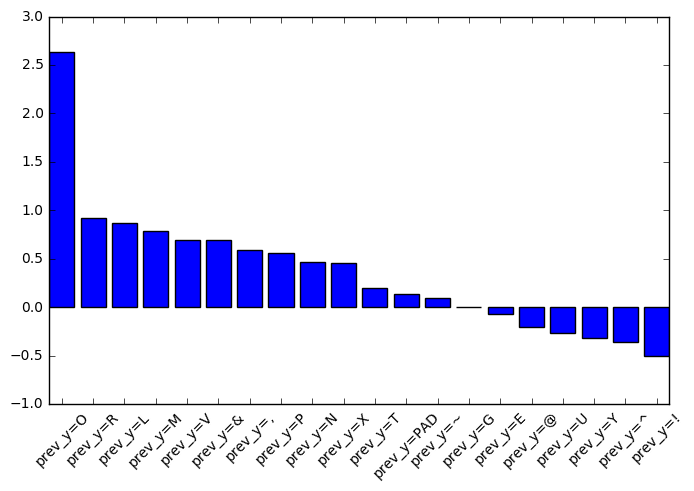

In [27]:
memm_1.plot_lr_weights('V',feat_filter=lambda s: s.startswith("prev_"))

### Beam Search
Greedy search approach is an **approximate solution** to $\argmax$ problem 

One way to improve over greedy search is to maintain a **beam** of $k$-best solutions in each step 

This enables initially weaker solutions to remain in the beam and move up the ranks in later steps in case they are more consistent with future observations

Technically a $k$-best beam search proceeds as follows. Let $L$ be the label set.

1. Initialise a beam $B \leftarrow \left[(\text{PAD}, 0) \right]$ of partial solutions $(\y,s)$ where $s$ is the partial log-score of $\y$. 
1. **for** $i$ in $1 \ldots |\x|$:
    1. Let $C\leftarrow \{\}$ be the next beam candidates.
    1. **for** $\y, s$ in $B$ and $y$ in $L$: 
        1. $C \leftarrow C \cup \{ (\y \| y, s + \log \prob_\params(y|\x,y_{i-1},i)) \} $
    1. Let $B\leftarrow k\text{-highest-scoring}(C)$ be the $k$ pairs $(\y, s)$ with highest scores.
1. **Return** $\y$ with highest score in $B$. 

Note that a slightly faster version can use a priority queue. 

In Python we can implement this algorithm like so:

In [28]:
def memm_beam_search(memm, x, width=2):
    beam = [([],0.)]
    history = [beam]
    for i in range(0, len(x)):
        # use priority queue 
        candidates = []
        for (prev,score) in beam:
            scores = memm.predict_scores(x, i, prev)
            for label_index,label_score in enumerate(scores):
                candidates.append((prev + [memm.labels()[label_index]], score + label_score))
        beam = sorted(candidates, key=lambda x: -x[1])[:width]
        history.append(beam)
    return beam, history
            
def batch_predict(data, beam_predictor):
    return [beam_predictor(x)[0][0][0] for x,y in data]

seq.accuracy(dev, batch_predict(dev, lambda x: memm_beam_search(memm_1, x, 10)))

0.8129794733568318

* With beam of size 10 accuracy improves only marginally
* You can try other beam sizes (leading to longer runtimes) but likely will not see substantial improvements

Is this because we already finding solutions with highest probability, or because higher probability doesn't necessarily mean higher accuracy? 

We can test how many per-token predictions differ when comparing greedy search to a beam search of a given width, simply calculating their accuracies relative to each other:

In [29]:
seq.accuracy(memm_greedy_predict(memm_1, dev), batch_predict(dev, lambda x: memm_beam_search(memm_1, x, 10)))

0.975533900062202

We notice that about 4% of the tokens receive different labels, simply searching for higher scoring sequences

This suggest that we frequently find higher probability sequences, but that these are not necessarily more correct

We can also calculate the average log probability of the argmax sequence using different beam sizes

Again we see that there is a substantial difference between scores, they are just not reflected in task accuracy 

In [30]:
sum([memm_beam_search(memm_1, x, 1)[0][0][1] for x,y in dev]) / len(dev)

-3.1982580986830151

In [31]:
sum([memm_beam_search(memm_1, x, 5)[0][0][1] for x,y in dev]) / len(dev)

-3.1442567645564075

Beam search is a 

* simple and often effective way to find sequences (or other structures) with higher probability

However, often it is also 

* inefficient in the sense that it does not fully **leverage the factorisation structure** and conditional independences

Probability of a label $y_i$ only depends on the previous label $y_{i-1}$

* any earlier labels have no impact on the term $\prob(y_i|\x,y_{i-1},i)$ 

With this in mind let us follow the beam for an example instance     

In [32]:
example = 56
beam, history = memm_beam_search(memm_1, dev[example][0],2)
seq.render_beam_history(history, dev[example], end=17)

Search *frontier*, the most recent label in each of the hypotheses, often has very little diversity

* for the word "of" it is very certain of label "P" 
* for the adjective "better" of "better way" the frontier contains "R" (adverb) twice, 
* and the gold label "A" (adjective) not at all. 

This leads to an error here

We can fix this error by simply increasing the beam size to 4. You can test this above. In this case "A" barely makes it into the beam, and becomes the winning label in the next step as it fits better to the noun "way". 

ignores the factorization or dependency structure of the model. 

In this particular case labels only depend on the previous label. 

This means that it makes no sense to maintain more than one hypothesis with the same frontier label in the beam. One only needs to remember the highest scoring sequence with that frontier label. 

"Proof": 
* consider two partial sequences $\y$ and $\y'$ of length $l$ with the same last label $t=y_l=y'_l$
* Assume $s = \sum_{i}^0 \log \prob(y_i|\x,y_{i-1},i)$  is larger than $s' = \sum_{i}^0 \log \prob(y'_i|\x,y'_{i-1},i)$ of $\y'$ 
* Assume label $y_{l+1}$ maximises $\prob(y_{l+1}|\x,t,i+1)$

Then log probability of $\y \| y_{l+1}$ is larger than the log probability of $\y' \| y_{l+1}$ and hence there is no need to carry around $\y'$.   

## Viterbi 

leverage conditional independences of the model directly

* maintaining a map $\alpha_i(l)$ from label $l$ and token index $i$ to score $\log \prob(\y|\x)$ of highest scoring partial sequence $\y$ ending in label $l$ at token $i$ 
* For each pair $(l,i)$ we also remember the sequence $\y$ that yielded that score in a map $\beta_i(l)$ 

The algorithm initialises $\alpha_{1}(l) =\log \prob(l|\x,\text{PAD},1)$ and then updates the $\alpha$ map via the following recursion:

$$
\alpha_i(l) = \max_y \alpha_{i-1}(y) + \log \prob(l|\x,y,i)  
$$

and in $\beta_i(l)$ we store the 'winning' $y$ from the $\max$ term. 

Once we reached the sequence end the result sequence can be inferred by finding the label $l$ with highest $\alpha_{|\x|}(l)$ and then back-tracking using $\beta$. It is easy to show that this algorithm returns the *optimal* solution to the prediction/search problem, assuming that labels only depend on the previous label. (Exercise: extend to $n$ previous labels) 

Below we implement a beam version of the viterbi algorithm. In this version we restrict the maximisation that defines $\alpha_i(l)$ to only range over the top $k$ highest scoring previous labels $y$.   

In [33]:
from collections import defaultdict
import math
def memm_viterbi_search(memm, x, width=2):
    labels = memm.labels()
    # initialise
    alpha = [{}]
    beta = [{}]
    for label_index, label_score in enumerate(memm.predict_scores_hist(x, 0, ["PAD"])):
        label = labels[label_index]
        alpha[0][label] = label_score
        beta[0][label] = "PAD"
    
    # prune
    seq.prune_alpha_beta(alpha[0], beta[0], width)
    
    # recursion 
    for i in range(1, len(x)):
        alpha.append(defaultdict(lambda: -math.inf))
        beta.append({})
        for p in alpha[i-1].keys():
            for label_index, label_score in enumerate(memm.predict_scores_hist(x, i, [p])):
                label = labels[label_index]
                new_score =  alpha[i-1][p] + label_score
                if new_score > alpha[i][label]:
                    alpha[i][label] = new_score
                    beta[i][label] = p
        # prune
        seq.prune_alpha_beta(alpha[i], beta[i], width)
    
    # convert to beam history to be used in the same way beam search was used.  
    history = seq.convert_alpha_beta_to_history(x, alpha, beta)
    return history[-1], history

beam, history = memm_viterbi_search(memm_1, dev[example][0],2)
seq.render_beam_history(history, dev[example], 17)

Crucially, for the same beam size we now keep the correct labelling of "better" in the beam and reach a better solution, both in terms of log probability and actual accuracy. 

This improvement in log probabilities does not always lead to higher global accuracy:

In [34]:
seq.accuracy(dev, batch_predict(dev, lambda x: memm_viterbi_search(memm_1, x, 2)))

0.8140161725067385

## Label Bias Problem

MEMMs multiply several *locally* normalised transition probabilities to arrive at a sequence probability

* for each token $i$ and given previous state $y_{i-1}$ sum of transition scores into next states $\sum_{y_i} \prob_\params(y_i|\x,y_{i-1},i)$ equals 1

* This local normalisation makes training easy (why?), but it also leads to a problem. Consider two simple sequences "that works" and "that house". The former is a pronoun ("O") followed by a verb ("V"), the latter is a determiner ("D") followed by a noun ("N"). Let us assume that 

$$
\prob_\params(\text{D}|\x,\text{PAD},0) =\prob_\params(\text{O}|\x,\text{PAD},0) \approx 0.5,
$$

meaning that at the beginning of a sentence both the determiner and pronoun label for "that" have roughly the same probability 0.5. Now assume that in the training set determiners are always followed by nouns, and pronouns always by verbs. This would mean that 

$$
\prob_\params(\text{N}|\x,\text{D},i) = \prob_\params(\text{V}|\x,\text{O},i)  \approx 1
$$     

and hence transitions from these two states are completely independent of the observation. 

Now we have $\prob_\params(\text{D N}|\, \text{that works}) \approx 0.5$ and $\prob_\params(\text{O V}|\, \text{that works}) \approx 0.5$, and the same for the input "that house". This means that once we enter the "D" or "O" state, the following observations have no effect on the sequence probability. The reason is that MEMMs requires *all* incoming probability mass (0.5 in the above example) to a given state (such as "D" or "O") to be distributed among the outgoing states. If there is only one possible next state, then that next state will receive all the mass, regardless of the observation. In particular, the model cannot say "in state "D" and for observation "works", *all* labels are impossible. More generally, states with few outgoing distributions effectively ignore observations, and this creates a bias towards such states. This problem is known as the *label bias problem*. 

## CRF

[Conditional Random Fields (CRFs)](http://www.seas.upenn.edu/~strctlrn/bib/PDF/crf.pdf) have been developed to overcome the label bias. The core problem of MEMMs is local normalisation. CRFs replace this with *global* normalisation. That is instead of normalising across all possible next states $y_{i+1}$ given a current state $y_i$ and observation $\x$, the CRF normalises across all possible *sequences* $\y$ given observation $\x$. Formally the CRF is hence defined as follows:

$$
p_\params(\y|\x) = \frac{1}{Z_{\x}} \prod_i^{|\x|} \exp  \langle \repr(\x,y_{i-1},i), \params_{y_i} \rangle
$$

where $Z_{\x}=\sum_\y   \prod_i^{|\x|} \exp \langle \repr(\x,y_{i-1},i), \params_{y_i} \rangle$ is the *partition function*, a *global* normalisation constant depending on $\x$. Notably each term $\exp  \langle \repr(\x,y_{i-1},i), \params_{y_i} \rangle$ in the product can now take on values in $[0,\infty)$ as opposed to the MEMM terms in $[0,1]$.  

The name CRF stems from the fact they correspond to [Markov random fields](http://www.statslab.cam.ac.uk/~grg/books/hammfest/3-pdc.ps), globally conditioned on the observation $\x$. While in this chapter we focus on cases where the dependency structure corresponds to a linear chain, CRFs are more general and encompass any graphical structure. 

### Training Linear Chain CRFs

CRFs can be trained (as usual) by maximising the conditional log-likelihood of the data 

$$
CL(\params) = \sum_{(\x,\y) \in \train} \log \prob_\params(\y|\x).
$$

This is substantially harder than for MEMMs because the partition function makes it impossible to break up the objective into only per-token logistic regression terms. Instead the objective needs to be treated on a per-sequence basis. Conceptually this is not difficult: just as for logistic regression we need to calculate the gradient of the objective, and once we have this gradient, we choose a gradient descent/ascent method to optimise the function. The general CRF conditional log-likelihood is in fact a generalisation of the logistic regression objective, and hence the CRF gradient will look very similar to the gradient of logistic regression. We discuss this gradient, its derivation and calculation in more detail [TODO](todo). In this chapter we will only briefly discuss the gradient and what is necessary to calculate it. 

\begin{split}
  \nabla_{y'} CL(\params) =  \sum_{(\x,\y) \in \train} \sum^{|\x|}_i\repr(\x,y_{i-1},i) \delta(y_i,y') - p_\params(y',y_{i-1}|\x) \repr(\x,y_{i-1},i) 
\end{split}


### Prediction in Linear Chain CRFs

From the perspective of finding $\argmax_\y \prob_\params(\y|\x)$ we can treat the CRF just as the MEMM. The share the same factorisation/dependency structure and are just differently normalised. That is, we can again simply perform greedy search, use a beam or apply Viterbi. 

Below we train a CRF model using the same feature vectors as used for the MEMM model, and then do prediction via the Viterbi algorithm (this is the standard algorithm in most CRF libraries). 

In [35]:
crf_1 = seq.CRFSequenceLabeler(feat_4, train)
seq.accuracy(dev, crf_1.predict(dev))

0.8206510470661414

A notable 1% point improvement over the MEMM model that essentially comes from free in the sense that we are using exactly the same feature representation and are just changing from local to global normalisation.

## Test

In [36]:
util.Table([
        ["word", seq.accuracy(test, local_1.predict(test))],
        ["+ first @", seq.accuracy(test, local_2.predict(test))],
        ["+ cap", seq.accuracy(test, local_3.predict(test))],
        ["+ suffix", seq.accuracy(test, local_4.predict(test))],
        ["MEMM", seq.accuracy(test, memm_1.predict(test))],
        ["CRF", seq.accuracy(test, crf_1.predict(test))]       
    ])

word,0.6511465324384788
+ first @,0.7572706935123042
+ cap,0.7760067114093959
+ suffix,0.7971196868008948
MEMM,0.8111017897091722
CRF,0.8239653243847874


## Background Material
* [Tackling the Poor Assumptions of Naive Bayes Text Classifiers](https://people.csail.mit.edu/jrennie/papers/icml03-nb.pdf), Rennie et al, ICML 2003 
* [Simple Sentiment Classification](http://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf) 
* [MEMM](http://www.ai.mit.edu/courses/6.891-nlp/READINGS/maxent.pdf)